1. EDA on the CINIC-10 Dataset

In [90]:
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import data,exposure
import random
from operator import itemgetter
from skimage.color import rgb2gray

Todo:

1. Maybe HOG white pixels between classes
2. Merge train and valid splits into 1 and perform 80-20 split
    1. Essentialy you want to take 5400 images from each class from valid and move it to test
3. Prepare the whole pipeline

In [39]:
DATASET_DIR = './Dataset'

#### Distribution of datapoints per class
- Each class in each split contains 9000 images

In [41]:


classCounts = {"train":{},"test":{},"valid":{}}
dirPath = os.path.join(DATASET_DIR,'test')
for classFolder in os.listdir(dirPath):
    classCounts['test'][classFolder] = len(os.listdir(os.path.join(dirPath, classFolder)))

dirPath = os.path.join(DATASET_DIR,'train')
for classFolder in os.listdir(dirPath):
    classCounts['train'][classFolder] = len(os.listdir(os.path.join(dirPath, classFolder)))

dirPath = os.path.join(DATASET_DIR,'valid')
for classFolder in os.listdir(dirPath):
    classCounts['valid'][classFolder] = len(os.listdir(os.path.join(dirPath, classFolder)))

for splitName, splitObject in classCounts.items():
    print(f"Class distribution for {splitName}")
    for subfolder, count in splitObject.items():
        print(f"{subfolder}: {count}")


Class distribution for train
airplane: 9000
automobile: 9000
bird: 9000
cat: 9000
deer: 9000
dog: 9000
frog: 9000
horse: 9000
ship: 9000
truck: 9000
Class distribution for test
airplane: 9000
automobile: 9000
bird: 9000
cat: 9000
deer: 9000
dog: 9000
frog: 9000
horse: 9000
ship: 9000
truck: 9000
Class distribution for valid
airplane: 9000
automobile: 9000
bird: 9000
cat: 9000
deer: 9000
dog: 9000
frog: 9000
horse: 9000
ship: 9000
truck: 9000


In [61]:
def parse_filepath(filepath):
    path, filename = os.path.split(filepath)
    filename, ext = os.path.splitext(filename)
    fileSize = os.path.getsize(filepath)
    im = Image.open(filepath)
    width, height = im.size
    return int(fileSize)/1024, int(width), int(height)

In [62]:
train_files = glob.glob(os.path.join(DATASET_DIR,'train/**/*.png'),recursive=True)
valid_files = glob.glob(os.path.join(DATASET_DIR,'valid/**/*.png'),recursive=True)
test_files = glob.glob(os.path.join(DATASET_DIR,'test/**/*.png'),recursive=True)


attributes = list(map(parse_filepath, train_files+valid_files+test_files))

In [63]:
df = pd.DataFrame(attributes)
df['file'] = train_files + valid_files+test_files
df.columns = [ 'file size (KB)','width','height', 'file']

All images are of 32x32 resolution, the average image size is 2.67 KB

In [64]:
df.describe()

,file size (KB),width,height
count,270000.000000,270000.0,270000.0
mean,2.678568,32.0,32.0
std,2.520497,0.0,0.0
min,0.174805,32.0,32.0
25%,2.196289,32.0,32.0
50%,2.398438,32.0,32.0
75%,2.595703,32.0,32.0
max,480.496094,32.0,32.0


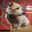

In [65]:
Image.open(df.loc[df['file size (KB)'].idxmax()]['file'])

In [68]:
color_distributions = []
for img_path in train_files+valid_files+test_files:
    img = cv2.imread(img_path)
    color_distribution = np.bincount(img.flatten(), minlength=256)
    color_distributions.append(color_distribution)

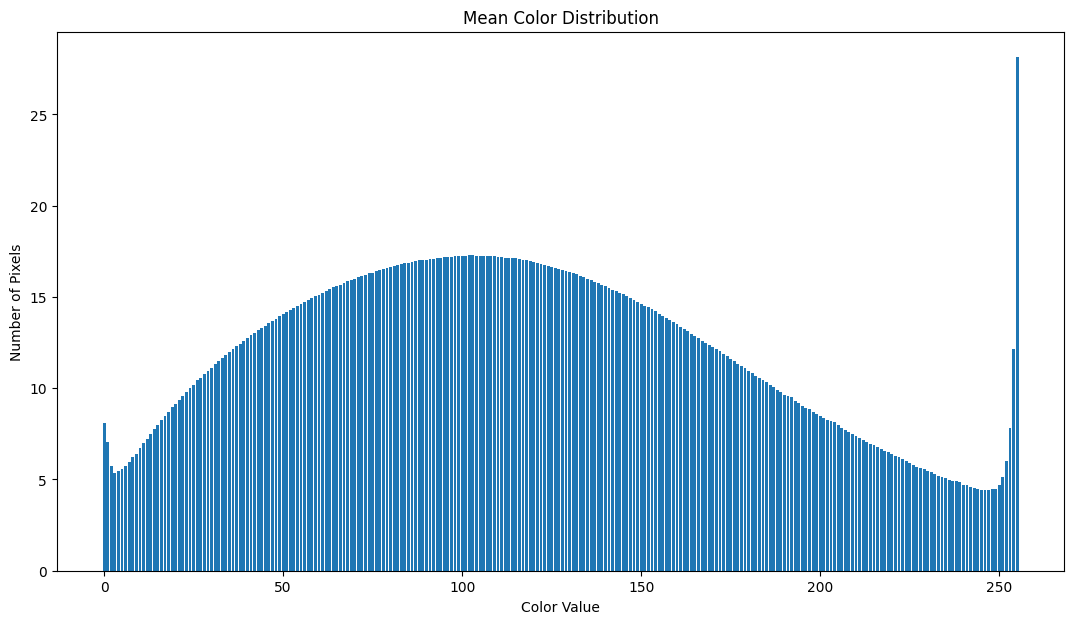

In [69]:
color_distributions = np.array(color_distributions)
color_distributions


mean_color_distribution = np.mean(color_distributions, axis=0)
plt.figure(figsize = (13,7))
plt.bar(np.arange(256), mean_color_distribution)
plt.title("Mean Color Distribution")
plt.xlabel("Color Value")
plt.ylabel("Number of Pixels")
plt.show()

RGB Intensities

In [72]:
# For each image get average red, green and blue channel
rgbMeans = []
for img_path in train_files+valid_files+test_files:
    try:
        img = cv2.imread(img_path)
        
        avgR = np.mean(img[:,:,2])
        avgG = np.mean(img[:,:,1])
        avgB = np.mean(img[:,:,0])
        path, filename = os.path.split(img_path)
        filename, ext = os.path.splitext(filename)
    
        rgbMeans.append([os.path.basename(os.path.dirname(img_path)), avgR, avgG, avgB])
    except Exception as e:
        print("Couldn't parse the file: " + filename)

# Group it by age

groups = {}
for l in rgbMeans:
    groups.setdefault(l[0], []).append(l)

rgbMeansGrouped = list(groups.values())

# Sort it

rgbMeansGrouped = sorted(rgbMeansGrouped, key=itemgetter(0))

# Calculate average for each group

meanGroupedR = []
meanGroupedG = []
meanGroupedB = []
xAxes = []

for classGroup in rgbMeansGrouped:
    sumR = 0
    sumG = 0
    sumB = 0
    for imageData in classGroup:
        sumR = sumR + imageData[1]
        sumG = sumG + imageData[2]
        sumB = sumB + imageData[3]
    meanGroupedR.append(sumR/len(classGroup))
    meanGroupedG.append(sumG/len(classGroup))
    meanGroupedB.append(sumB/len(classGroup))
    xAxes.append(classGroup[0][0])

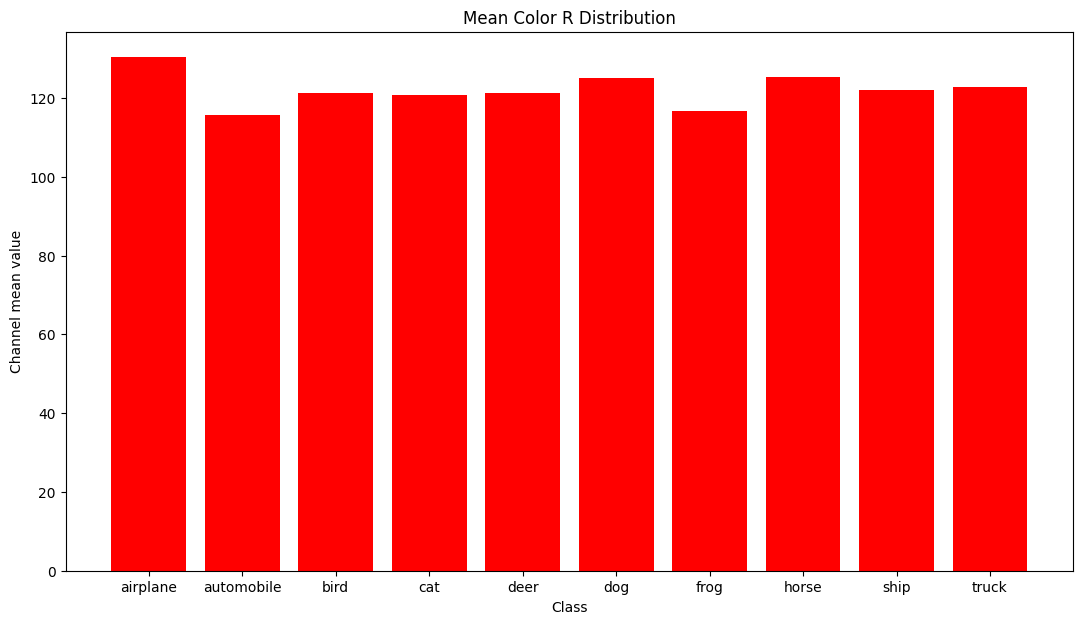

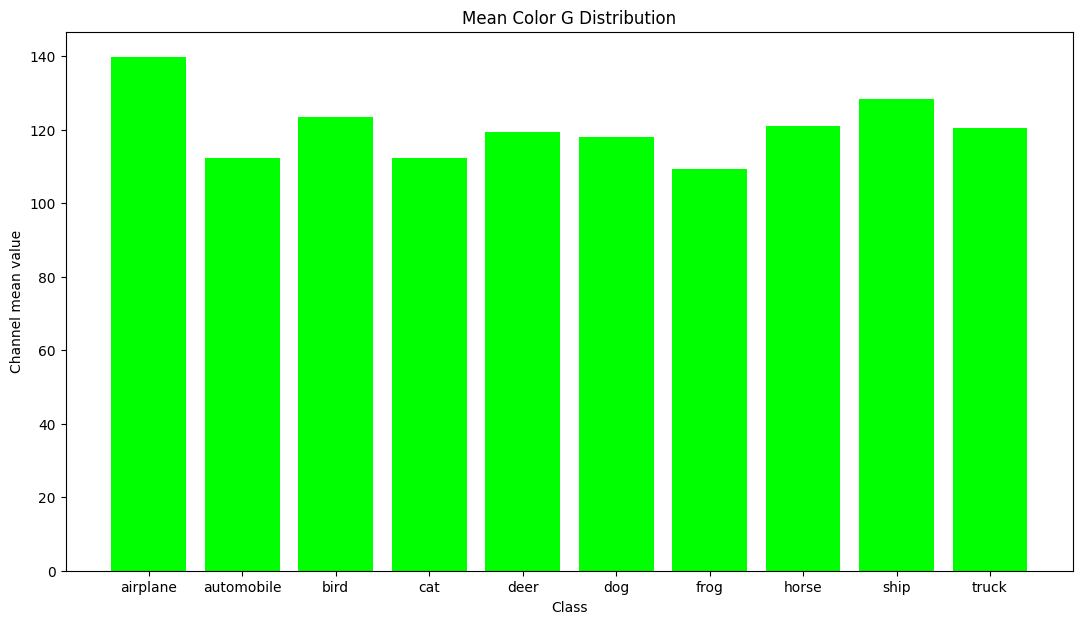

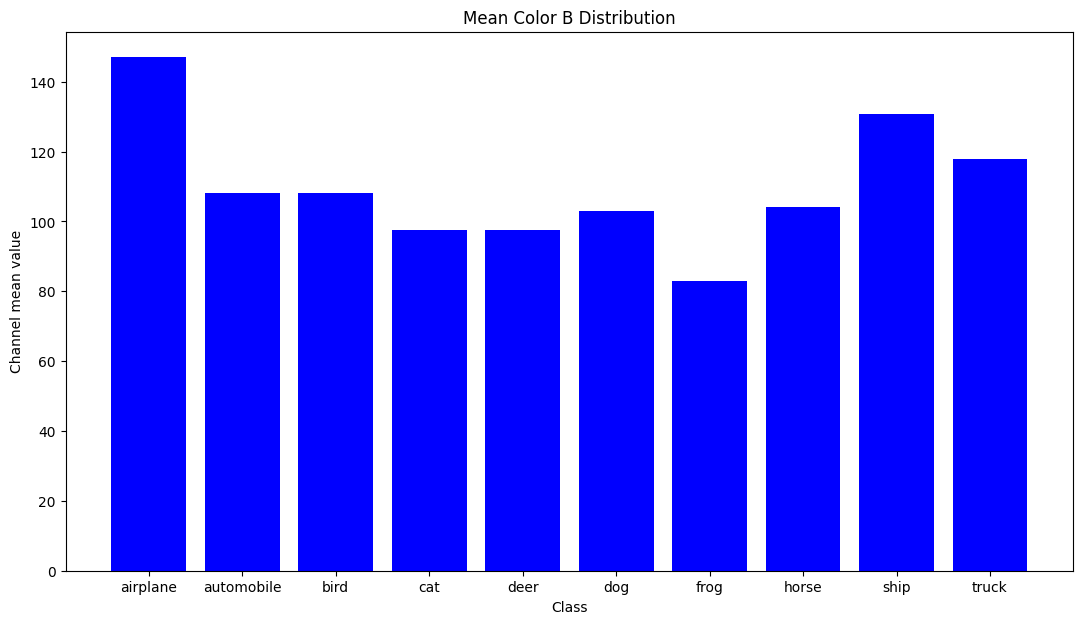

In [73]:
# Plot each
plt.figure(figsize = (13,7))
plt.bar(xAxes,meanGroupedR, color=(1, 0, 0, 1))
plt.title("Mean Color R Distribution")
plt.xlabel("Class")
plt.ylabel("Channel mean value")
plt.show()

plt.figure(figsize = (13,7))
plt.bar(xAxes,meanGroupedG, color=(0, 1, 0, 1))
plt.title("Mean Color G Distribution")
plt.xlabel("Class")
plt.ylabel("Channel mean value")
plt.show()

plt.figure(figsize = (13,7))
plt.bar(xAxes,meanGroupedB, color=(0, 0, 1, 1))
plt.title("Mean Color B Distribution")
plt.xlabel("Class")
plt.ylabel("Channel mean value")
plt.show()

HOG example (Histogram of Oriented Gradients)

./Dataset\train\airplane\cifar10-train-33328.png


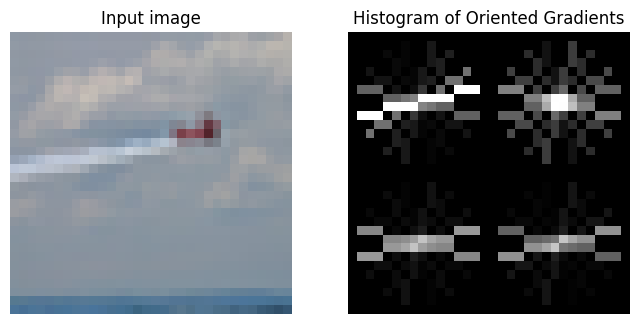

In [74]:
image = imread(train_files[999])
print(train_files[999])
fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

HOG comparison between classes

In [104]:
hogMeans = []
hogStandardDeviations = []

for filePath in train_files+valid_files+test_files:
    path, filename = os.path.split(filePath)
    filename, ext = os.path.splitext(filename)
    image = imread(filePath)
    if len(image.shape) == 3:
        image = rgb2gray(image)

    fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True
    )
    fileClass = os.path.basename(os.path.dirname(filePath))
        
    hogMeans.append([np.mean(fd),fileClass])
    hogStandardDeviations.append([np.std(fd),fileClass])


<Axes: xlabel='HOG standard deviation', ylabel='Class'>

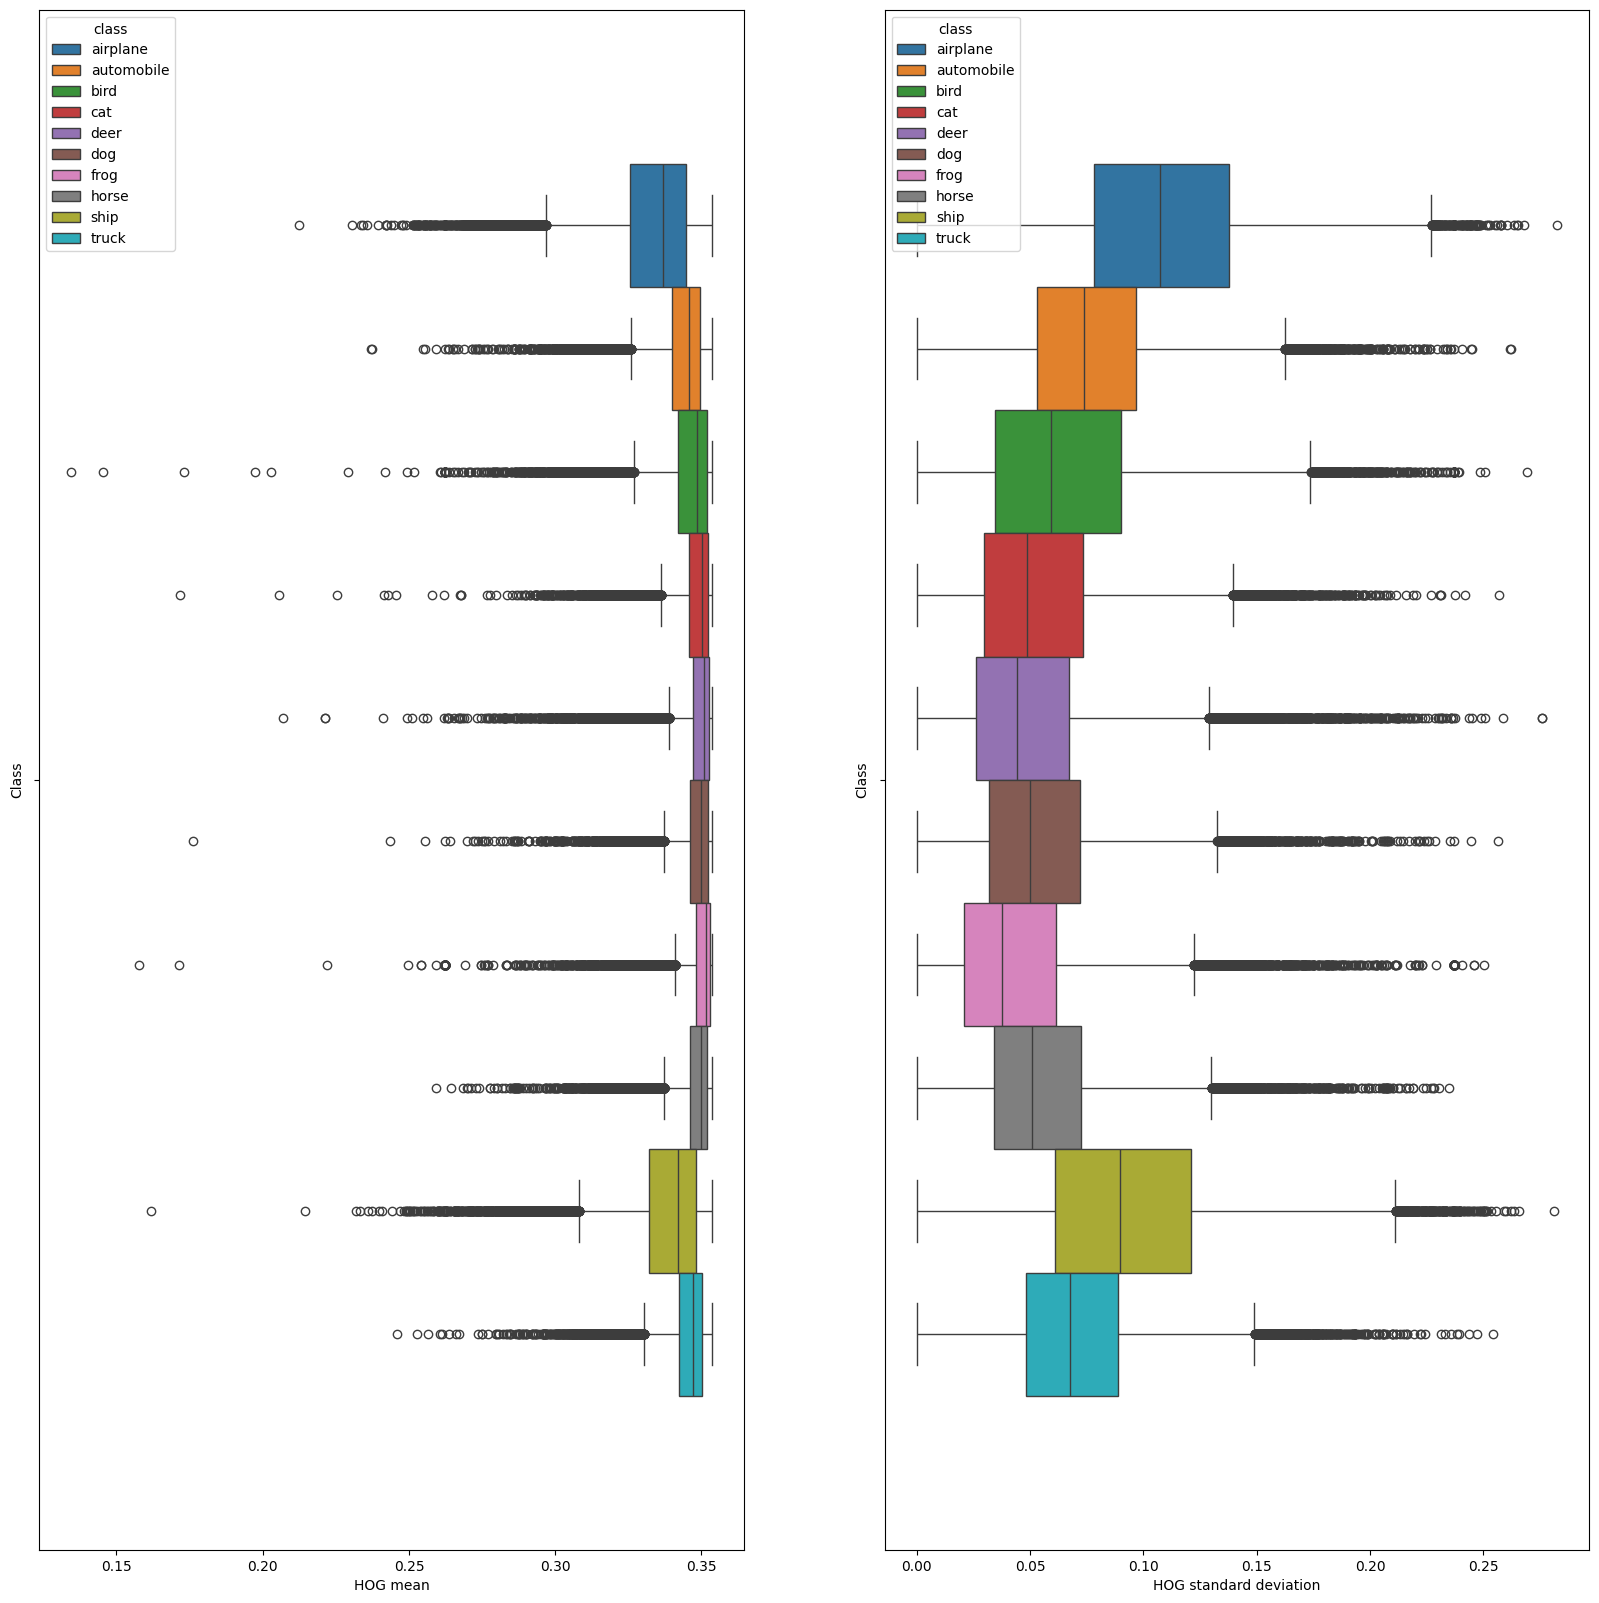

In [110]:
hogMeansDF = pd.DataFrame(hogMeans, columns=['value', 'class'])
hogStandardDeviationsDF = pd.DataFrame(hogStandardDeviations, columns=['value', 'class'])
f, axes = plt.subplots(figsize=(20, 20), ncols=2, nrows=1)
axes[0].set_xlabel('HOG mean')
axes[0].set_ylabel('Class')
axes[1].set_xlabel('HOG standard deviation')
axes[1].set_ylabel('Class')
# print(hogMeansDF.tail())
sns.boxplot( data=hogMeansDF, orient="h", x="value", hue='class',ax=axes[0])
sns.boxplot( data=hogStandardDeviationsDF, orient="h", x="value", hue='class',ax=axes[1])

In [112]:
hogImagesWhitePixels = {}

for filePath in train_files+valid_files+test_files:
    path, filename = os.path.split(filePath)
    filename, ext = os.path.splitext(filename)
    image = imread(filePath)
    if len(image.shape) == 3:
        image = rgb2gray(image)
    fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    )
    fileClass = os.path.basename(os.path.dirname(filePath))
    if fileClass not in hogImagesWhitePixels.keys():
        hogImagesWhitePixels[fileClass]=[]
    hogImagesWhitePixels[fileClass].append(np.sum(image == 255))

In [120]:
whitePixelsHOG = []
print("Average amount of white pixels in HOG per class")
for fileClass in hogImagesWhitePixels.keys():
    whitePixelsHOG.append([fileClass,np.mean(hogImagesWhitePixels[fileClass])])
    # print(fileClass +"\t"+ str(np.mean(hogImagesWhitePixels[fileClass])))
print(pd.DataFrame(whitePixelsHOG, columns=['Class', 'Average white pixels']))

Average amount of white pixels in HOG per class
        Class  Average white pixels
0    airplane              0.188556
1  automobile              0.009000
2        bird              0.006259
3         cat              0.000000
4        deer              0.000000
5         dog              0.006815
6        frog              0.036741
7       horse              0.017815
8        ship              0.025481
9       truck              0.000000


Examples

./Dataset\train\frog\n01653509_2683.png


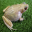

./Dataset\train\bird\n02054502_4612.png


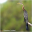

./Dataset\train\automobile\n03141065_9665.png


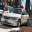

./Dataset\train\bird\n01531512_3953.png


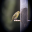

In [77]:
for i in range(4):
    image = random.randint(1,len(df['file'])-1)
    print(df['file'][image])
    img = Image.open(df['file'][image])
    display(img)

In [40]:

# Need to load the files with division
train_files = glob.glob(os.path.join(DATASET_DIR,'train/**/*.png'),recursive=True)